In [1]:
import numpy as np
import pandas as pd
import glob
import string

import sys,traceback
import ast
from datetime import date
import datetime as dt
import json

from sklearn.model_selection import train_test_split,cross_val_score
from nltk.tag import pos_tag
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
all_data = pd.DataFrame()
for f in glob.glob("./data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [3]:
train, test = train_test_split(all_data, test_size = 0.2)

In [4]:
train.created_at.describe()

count                1931
unique               1547
top       11/3/2014 23:48
freq                  129
Name: created_at, dtype: object

In [5]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        #_date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        time = date_split[1]
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [6]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity
    
def get_Noun(x):
    word = str(x).strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
    return count

def return_dict(x):
    if not pd.isnull(x) and x.find('_json=') != -1:
        x = x[x.find('_json=')+6:x.find(', coordinates=')]
        x = ast.literal_eval(x)
        return x
    else:
        return None

def status_created_date(x):
    if not pd.isnull(x):
        x = return_dict(x)
        if x is not None:
            x = returnDates(x['created_at'],True)
            return x
    return pd.to_datetime('04/08/2017', format='%m/%d/%Y', errors='coerce')

def in_reply_stats(x):
    x = return_dict(x)
    if x is not None:
        if x['in_reply_to_screen_name'] is not None:
            return 1
    return 0

def tweet_text_data(x):
    x = return_dict(x)
    if x is not None:
        return x['text']
    return 'a'

In [7]:
def status_created_at(df):
    df['status_created_at'] = df.status.apply(status_created_date)
    return df

def in_reply_data(df):
    df['in_reply_data'] = df.status.apply(in_reply_stats)
    return df

def tweet_text(df):
    df['tweet_text'] = df.status.apply(tweet_text_data)
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def account_age(df):
    df['acc_age'] = (df['status_created_at'] - df['modified_date'])
    df['acc_age'] = df.acc_age.apply(lambda  x:int(x.days))
    for index,row in df.iterrows():
        if row['acc_age'] < 0:
            value = abs(int((pd.to_datetime('04/08/2017', format='%m/%d/%Y', errors='coerce') - pd.to_datetime(row['modified_date'])).days))
            df.set_value(index,'acc_age',value)
    df['acc_age'] += 1
    return df;

def tweets_per_day(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    return df 

def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df
    
def simplfy_followerscount(df):
    bins = (0, 46,358,14917,96321560,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.followers_count, bins, labels=group_names)
    df.followers_count = categories
    return df  

def simplfy_friendscount(df):
    bins = (0, 10,197,671,978964,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['friends_count'], bins, labels=group_names)
    df.friends_count = categories
    return df    

def simplfy_listedcount(df):
    df.loc[:,'listedcount']= df.listedcount.apply(lambda x: int(x)+1)
    bins = (0, 2,18,360,222411,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df['listedcount'], bins, labels=group_names)
    df.loc[:,'listedcount'] = categories
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    bins = (0,2,25,484,714021,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.favourites_count, bins, labels=group_names)
    df.loc[:,'favourites_count']= categories
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    bins = (0,178,2290,10025,6863363,sys.maxint)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile', '5_quartile']
    categories = pd.cut(df.statuses_count, bins, labels=group_names)
    df.loc[:,'statuses_count']= categories
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang','status','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    return df

def transform_features(df):
    df = status_created_at(df)
    df = format_date(df)
    df = account_age(df)
    df = tweets_per_day(df)
    df = in_reply_data(df)
    df = ff_ratio(df)
    df = tweet_text(df)
    #df = simplfy_followerscount(df)
    #df = simplfy_friendscount(df)
    #df = simplfy_listedcount(df)
    #df = simplfy_favouritescount(df)
    #df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = diversity(df)
    df = drop_features(df)
    return df

train = transform_features(train)
all_data = transform_features(all_data)
train.head()

C:\Users\hp\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hp\Anaconda2\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hp\Anaconda2\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,...,modified_hour,acc_age,tweets_per_day,in_reply_data,ff_ratio,tweet_text,sn_length,desc_length,diversity,null_url
566,nope_nooope,NaN,NaN,184,2,10,0,False,1258,True,...,4,313,4.019169,0,92.000000,NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE N...,11,3,0.454545,0
1658,skibluemountain,Official Twitter for Blue Mountain - PA's High...,https://t.co/fJQurMyW9f,11634,1274,253,5616,True,5901,False,...,16,3007,1.962421,0,9.131868,"The votes are in, you're most excited for our ...",15,137,0.800000,1
487,man_products,PRODUCTS FOR MEN!! A bot by @NoraReed. Thanks ...,http://t.co/gvvOA90STT,2617,2,98,4,False,5814,False,...,6,697,8.341463,0,1308.500000,FINALLY: INDEPENDENT-SCENTED JERKY,12,83,1.000000,1
427,GraphicScoreBot,"Hourly graphic scores to inspire musicians, co...",https://t.co/jgcn7jPp0t,602,2,42,0,False,10302,True,...,2,449,22.944321,0,301.000000,E N D,15,121,0.800000,1
1825,nightsailer,"A Perl/PHP programmer, Co-founder & Architect ...",http://t.co/iNLW4wOvZB,380,209,0,33,False,452,True,...,16,1875,0.241067,1,1.818182,@ParallelsCares I got a new computer but can't...,11,72,0.909091,1


In [55]:
train[train['screen_name'] == 'airport_exe']

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,...,modified_hour,acc_age,tweets_per_day,in_reply_data,ff_ratio,tweet_text,sn_length,desc_length,diversity,null_url


In [56]:
train['tweet_text'].describe()

count                                                  1931
unique                                                 1456
top       Enter now for your chance to Win! https://t.co...
freq                                                    132
Name: tweet_text, dtype: object

In [57]:
np.where(pd.isnull(all_data['tweet_text']))

(array([], dtype=int64),)

In [37]:
train['has_link_in_text'] = train.tweet_text.apply(lambda x : 'a' if (x is None) else x)

In [58]:
all_data['has_link_in_text'] = all_data.tweet_text.apply(lambda x : 1 if (x.find('https') != -1) else 0)

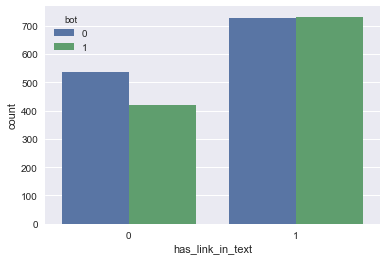

In [59]:

sns.countplot(x='has_link_in_text', hue='bot', data=all_data)

In [2]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
features = ['friends_count','verified','default_profile','desc_length','diversity','null_url']
model = LogisticRegression(n_jobs=2,C=1e5,fit_intercept=True,penalty='l1')
model = model.fit(train[features], train['bot'])

NameError: name 'train' is not defined

In [19]:
model.score(train[features], train['bot'])

0.74313827032625579

In [20]:
a = cross_val_score(model, train[features], train['bot'], cv=10)
print a,np.mean(a)

[ 0.71134021  0.72680412  0.73195876  0.67525773  0.71649485  0.75647668
  0.765625    0.765625    0.74479167  0.72395833] 0.731833235404


In [30]:
from sklearn import svm
svc = svm.SVC(kernel='rbf')
svc.fit(train[features], train['bot'])  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
a = cross_val_score(svc, test[features], test['bot'], cv=10)
print a,np.mean(a)

[ 0.71428571  0.65306122  0.59183673  0.67346939  0.71428571  0.6875
  0.64583333  0.66666667  0.68085106  0.63829787] 0.666608771168


In [100]:
robust_scaler = preprocessing.RobustScaler()
train['friends_count'] = robust_scaler.fit_transform(train['friends_count'])

C:\Users\hp\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\hp\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\hp\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or 

In [101]:
train.friends_count.head()

1544    2.092391
1692   -0.103261
207    -0.340580
2190   -0.298913
712    -0.346014
Name: friends_count, dtype: float64